This is an intro / tutorial notebook for getting started with GTFS data.  

It is based on work that is shown on my dev blog [simplistic.me](http://simplistic.me/tag/gtfs.html). Posts there are not updated to current versions, mine or other packages'. Still, do check it out and feel free to comment or post an issue or pull request.

This is only one basic workflow which I like. You can find many more examples for working with GTFS online. There are tools and packages in many languages.

THE place to start is [awesome-transit](https://github.com/CUTR-at-USF/awesome-transit). 

TODO: Add more tools to this notebook - peartree, GTFSTK, UrbanAccess, Pandana

## Installation
TODO: Go to open-bus README (this needs to be there)

1. Install Anaconda3
1. Create a (call it openbus or something indicative): `conda create -n openbus`
1. Install everything on requirements.txt
    1. partridge and peartree require pip. 
    1. the rest you should install using `conda install`
1. Run JupyterLab or Jupyter Notebook

## Imports and config

In [13]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [54]:
import pandas as pd
import partridge as ptg
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import datetime

from gtfs_utils import *

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('Set2', 10)

## Getting the data
Three main options:
1. Tap into the source: We have some functions for working with [MoT's FTP](#FTP).
1. Our archive on [Amazon S3](#S3-archive)
1. [TransitFeeds](#TransitFeeds)' Archive

You can go to our redash interface if you prefer to work with SQL (can't attest to what the state of it is at any given moment).

### FTP

In [15]:
get_ftp_dir()

['11-18-13  03:20PM       <DIR>          aspnet_client',
 '06-03-18  10:51PM                24144 ClusterToLine.zip',
 '06-03-18  10:51PM            166241157 israel-public-transportation.zip',
 '06-03-18  10:51PM               100818 Tariff.zip',
 '06-03-18  10:51PM                29295 TrainOfficeLineId.zip',
 '06-03-18  10:51PM              5914034 TripIdToDate.zip',
 '12-20-17  05:37PM                53105 zones.zip']

We have the expected file names in constant variables in `gtfs_utils`

In [16]:
GTFS_FILE_NAME

'israel-public-transportation.zip'

In [17]:
TARIFF_FILE_NAME

'Tariff.zip'

In [18]:
LOCAL_GTFS_ZIP_PATH = 'data/sample/latest_gtfs.zip' 
LOCAL_TARIFF_PATH = 'data/sample/latest_tariff.zip' 

get_ftp_file(file_name = GTFS_FILE_NAME, local_path = LOCAL_GTFS_ZIP_PATH)

FileExistsError: Local file 'data/sample/latest_gtfs.zip' already exists, consider changing name for archiving purposes, or use the `force` flag

By default we don't overide local files. But we can, by adding `force=True`

In [19]:
get_ftp_file(file_name = GTFS_FILE_NAME, 
             local_path = LOCAL_GTFS_ZIP_PATH, 
             force=True)

Done.


True

In [20]:
get_ftp_file(file_name = TARIFF_FILE_NAME, 
             local_path = LOCAL_TARIFF_PATH, 
             force=True )

Done.


True

### S3 archive
Another option is to get the files from our archive on S3. For now it does require credentials.

In [21]:
#!aws s3 cp s3://s3.obus.hasadna.org.il/2018-02-01.zip data/gtfs_feeds/2018-02-01.zip

### TransitFeeds
You can always turn to the great [TransitFeeds](http://www.transitfeeds.com) archive and search for the feed you want (MoT's feed is archived every about 2 weeks over there)

## Creating a `partridge` feed
We have a util function for getting a `partridge` feed object by by date.  

In [22]:
feed = get_partridge_feed_by_date(LOCAL_GTFS_ZIP_PATH, datetime.date.today())
type(feed)

partridge.gtfs.feed

* *Another option would be to use `ptg.get_representative_feed()` which finds the busiest day of the gtfs file and returns a feed for that day. Not showing this here*

The feed has in it all the (standard) files in the original GTFS zip, as [pandas](https://github.com/pandas-dev/pandas) DataFrames.

In [23]:
[x for x in dir(feed) if not x.startswith('_')]

['agency',
 'calendar',
 'calendar_dates',
 'config',
 'fare_attributes',
 'fare_rules',
 'feed_info',
 'frequencies',
 'get',
 'is_dir',
 'path',
 'read_file_chunks',
 'routes',
 'shapes',
 'stop_times',
 'stops',
 'transfers',
 'trips',
 'view',
 'zmap']

Figuring out geographical zones requires using another zip file on MoT's FTP, using `get_zones_df()`. Which returns a simple mapping `stop_code` -> (Hebrew) `zone_name` in a DataFrame as well.

In [24]:
zones = get_zones_df(LOCAL_TARIFF_PATH)
zones.head()

,stop_code,zone_name
0,2716,סובב ירושלים
1,2718,סובב ירושלים
2,2720,סובב ירושלים
3,2721,סובב ירושלים
4,2747,סובב ירושלים


## Tidy DataFrame
A (monstrous) merged DataFrame for fancy analysis can be got using `get_tidy_feed_df()`, whom you pass a partridge feed and extra dataframes you want to merge to it (only `zones` is used here).

This takes a few minutes (MoT's GTFS is big)

In [25]:
f = get_tidy_feed_df(feed, [zones])

and what you get is this:

In [26]:
f.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,stop_code,route_id,direction_id,route_short_name,route_long_name,agency_id,agency_name,zone_name
0,32184517_040618,21:36:00,21:36:00,37318,1,ירושלים מלחה,31.747801,35.188216,17078,22786,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל,סובב ירושלים
1,32184517_040618,22:19:00,22:19:00,37322,2,בית שמש,31.757821,34.989515,17074,22786,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל,אזור בית שמש
2,32184517_040618,22:41:00,22:41:00,37336,3,רמלה,31.928809,34.877304,17060,22786,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל,גוש דן
3,32184517_040618,22:45:00,22:45:00,37338,4,לוד,31.945234,34.875081,17058,22786,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל,גוש דן
4,32184517_040618,22:51:00,22:51:00,37334,5,לוד-גני אביב,31.966977,34.878790,17062,22786,1,NaN,ירושלים מלחה-ירושלים<->תל אביב מרכז-תל אביב יפו,2,רכבת ישראל,גוש דן


In the future I intend to make this more customizable (field selection, transformations and more). 

In [27]:
f.shape

(3151606, 16)

In [28]:
feed.stop_times.shape

(3151606, 8)

So we truly have all the stop times for one whole day of trips.

## Random examples

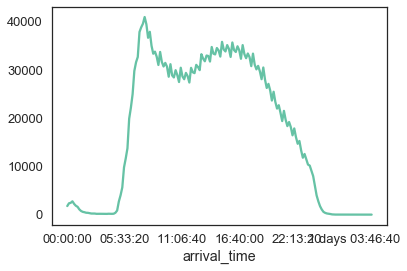

In [29]:
f.set_index('arrival_time').resample('10T').size().plot()

In [55]:
zone_counts = (f.set_index('arrival_time')
               .groupby([pd.Grouper(freq='10T'), 'zone_name'])
               .size().reset_index()
               .rename(columns={0: 'trips'}))

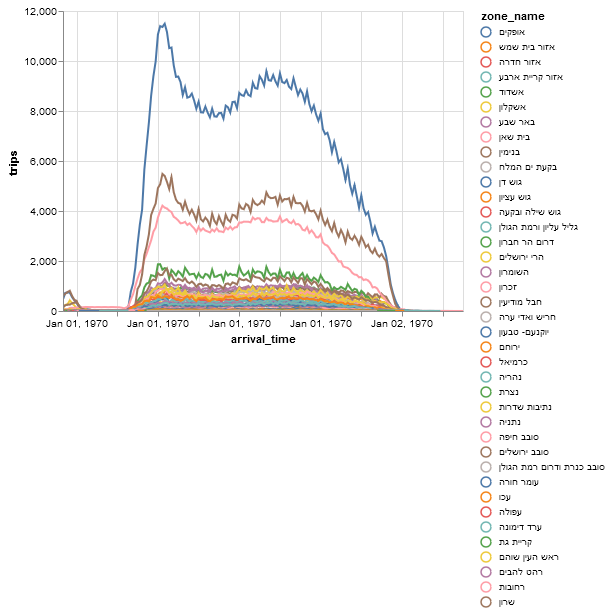

In [57]:
alt.Chart(zone_counts).mark_line().encode(
    x = 'arrival_time:T',
    y = 'trips',
    color = 'zone_name',
    tooltip = 'zone_name'
).interactive()